In [1]:
import sys, os
sys.path.append("./EntryGuidance")

from scipy.interpolate import interp1d
from scipy.integrate import odeint, cumtrapz 
from scipy.io import loadmat, savemat
import pickle
from time import time

import numpy as np
import chaospy as cp 
import matplotlib.pyplot as plt 

from Utils.boxgrid import boxgrid
import Utils.DA as da
from Utils.RK4 import RK4
from Utils.submatrix import submatrix 
from Utils import Unscented 
from Utils import MCF

from EntryGuidance.EntryEquations import Entry, EDL
from EntryGuidance.Simulation import Simulation, Cycle, EntrySim
from EntryGuidance.InitialState import InitialState
from EntryGuidance.Planet import Planet 
from EntryGuidance.Triggers import AltitudeTrigger
from EntryGuidance.VMC import VMC, velocity_trigger
from EntryGuidance.EntryVehicle import ConstantAeroEV

np.set_printoptions(suppress=True, precision=3)

# Monte Carlo Filtering Functions for Analysis

In [46]:
def range_error(xf, mean, mean_error):
    err = np.abs(xf[1] - mean)  # absolute error
    return err < mean_error # behavioral when error is less than the mean

def MCAnalyze(inputs, xf):
    mean = np.mean(xf[:,1], axis=0)
    err = np.mean(np.abs(xf[:,1] - mean))  #mean of absolute error
    
    data = MCF.mcsplit(inputs, xf, lambda x: range_error(x, mean, err))
    MCF.mcfilter(*data, plot=True, input_names=['h0','s0','v0','fpa0'], ks_threshold=0, p_threshold=0.3)

# DDP Controller Definition

In [133]:
data['mean'][2]

array([  0.   ,  13.031,  21.029, ..., 424.668, 425.368, 426.063])

In [149]:
def smooth_sat(x, tuning=20):
    """Another saturation function, from 
    Saturated Robust Adaptive Control for Uncertain Nonlinear Systems using a new approximate model
    
    """
    q = 2*x-1
    return 0.5 + 0.25/tuning*np.log(np.cosh(tuning*(q+1))/np.cosh(tuning*(q-1)))

class ddp_controller:

    def __init__(self, data):
        v = data['v'].squeeze()
        u0 = data['u'][0] # feedfoward term 
        u0[-1] = u0[-2]
        u0 = np.append(u0, u0[-2])
        
        if data['u'].shape[0] < 4:
            if 'gains' in data:
                G = data['gains'].squeeze()
            else:
                G = data['input'][0][0][10].squeeze()
            K = lambda v: G
            print("Fixed Gain Controller, ", G)
        else:
            K = interp1d(v[:-1], data['u'][1:], bounds_error=False, fill_value=(data['u'][1:,-2], data['u'][1:,0]))
            
        self.K = K
        self.u = interp1d(v, u0, bounds_error=False, fill_value=(u0[-1],u0[0]))
        xr = np.vstack([data['Dm'], data['mean'][1:]])
        self.ref = interp1d(v, xr, bounds_error=False, fill_value=(xr[:,-1],xr[:,0]))
        

    def __call__(self, E, x, L, D):
        # compute error states, apply gains
        r,s,v,fpa,_ = x
        
        xr = self.ref(v)
        eD = D - xr[0]
        es = s/1000 - xr[2]
        ef = fpa - xr[1]
        K = self.K(v)
        if 0:
            print(K)
#             print(eD, es, np.degrees(ef))
#             print(xr)
        u = smooth_sat(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef)
#         u = np.clip(u, 0, 1)
#         u = np.clip(self.u(v) + K[0]*eD + K[1]*es + K[2]*ef, 0, 1)
        
#         u[np.isnan(u)] = 1
        
        return u

# Monte Carlo Functions

In [150]:
def MonteCarlo(data, N=2000, debug=False):
    """ Runs a monte carlo from a DDP solution and compares to UT results
    
        debug = True runs the unscented transform points to ensure those match 
    """
    P0 = data['input'][0][0][3]  # h fpa s (no velocity term) 
    
    mass = 5000.

    x0 = data['mean'].T[0]
    if debug:
        N = 7
        X0 = np.reshape(data['X0'].squeeze(), (3,N))
        X0[2] *= 1000 # data is in km, need meters 
        
    else:
        X0 = cp.MvNormal(x0, P0).sample(N, 'L')

    # reorder and add velocity terms - h s v gamma
    X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
    
    mc = VMC()
    mc.null_sample(N)

    mc.control = ddp_controller(data)
    mc.set_trigger(velocity_trigger(data['v'][-1]))

    vehicle = lambda CD,CL: ConstantAeroEV(1.408, 0.357, CD=CD, CL=CL)
    
    mc._run(X0, stepsize=[5, 0.1, 1], Ef=10000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

    mean = np.mean(mc.xf, axis=0)
    std = np.std(mc.xf, axis=0)
    std_ut = data['ut'][0][0][-1][0] # mean alt, low alt, 3*dr
    std_ddp = [data['stats'][0][0], data['stats'][0][0] - 3*data['stats'][0][3]**0.5, 3*data['stats'][0][5]**0.5]

    print("3-sigma Low Altitude\n\tDDP: {:.3f} km\n\tUT: {:.3f} km\n\tMC: {:.3f} km".format(std_ddp[1], std_ut[1], mean[0]/1000-3396.2-3*std[0]/1000))
    print("3-sigma DR\n\tDDP: {:.3f} km\n\tUT: {:.3f} km\n\tMC: {:.3f} km".format(std_ddp[2], std_ut[2], 3*std[1]/1000))        
    output = np.array([[std_ddp[1], std_ut[1], mean[0]/1000-3396.2-3*std[0]/1000], [std_ddp[2], std_ut[2], 3*std[1]/1000]])
    return {'output': output, 'mc': mc} 

In [136]:
def MonteCarloArray(mdir):
    """ Runs Monte Carlos for a variety of solutions and plots the results in a variety of ways
    Designed for sweeps over the objective function weights 
    """
    dlist = [loadmat(os.path.join(mdir,fname)) for fname in list(os.walk(mdir))[0][2] if '.mat' in fname]
    outputs = np.array([MonteCarlo(data, 2000)['output'] for data in dlist])
    outputs = np.asarray(outputs)
    w = np.squeeze([data['weights'] for data in dlist]).T

    best = np.argmin(outputs[:,1,2]) # lowest MC range error
    print(w.T[best])
    print(outputs[best,:,2]) # low alt, 3s range error 

    # Monte Carlo estimated results for different weights 
    hdraw = np.linspace(1.5, 6.5, 10)
    sdraw = np.linspace(2, 19, 10)
#     hdraw = np.linspace(4.25, 6.75, 10)
#     sdraw = np.linspace(0, 3, 10)

    try:
        plt.figure(figsize=(20, 6))
        plt.suptitle('3$\sigma$ low altitude (km)')

        plt.subplot(1, 3, 1)
        plt.tricontourf(w[0], w[1], outputs[:,0,0], hdraw)
        # plt.colorbar()
        plt.title('DDP')
        plt.subplot(1, 3, 2)
        plt.tricontourf(w[0], w[1], outputs[:,0,1], hdraw)
        plt.title('UT')

        plt.subplot(1, 3, 3)
        plt.tricontourf(w[0], w[1], outputs[:,0,2], hdraw)
        plt.title('MC')
        plt.colorbar()

        plt.figure(figsize=(20, 6))
        plt.suptitle('3$\sigma$ range errors (km)')
        plt.subplot(1, 3, 1)
        plt.title('DDP')

        plt.tricontourf(w[0], w[1], outputs[:,1,0], sdraw)
        plt.subplot(1, 3, 2)
        plt.title('UT')

        plt.tricontourf(w[0], w[1], outputs[:,1,1], sdraw)
        plt.subplot(1, 3, 3)
        plt.title('MC')
        plt.tricontourf(w[0], w[1], outputs[:,1,2], sdraw)
        plt.colorbar()

        # TODO: show error plots between DDP and MC in asbolute units and maybe also as a percent difference?
        plt.figure(figsize=(14, 6))
        plt.suptitle('DDP - MC (positive indicates an overprediction)')
        plt.subplot(1, 2, 1)
        plt.title('Altitude Error')
        plt.tricontourf(w[0], w[1], outputs[:,0,0]-outputs[:,0,2])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('Range Error')
        plt.tricontourf(w[0], w[1], outputs[:,1,0]-outputs[:,1,2])
        plt.colorbar()

        plt.show()
    except:
            pass
    return outputs

In [ ]:
# TODO: MC function that compares DDP controller to Apollo? Take the reference and get adjoints, perform a second VMC, then compare stats and plots 

# Single MC Analysis
Individualized plots, etc.

In [153]:
# data = loadmat(os.path.join("E:\\Documents\\GitHub\\Research\\Matlab",'Beta5.mat'))
data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep','Beta5.mat'))

sol = MonteCarlo(data, 1000, debug=True)

 
Generating 7 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 4.589 km
	UT: 4.579 km
	MC: 3.726 km
3-sigma DR
	DDP: 0.843 km
	UT: 1.386 km
	MC: 5.378 km


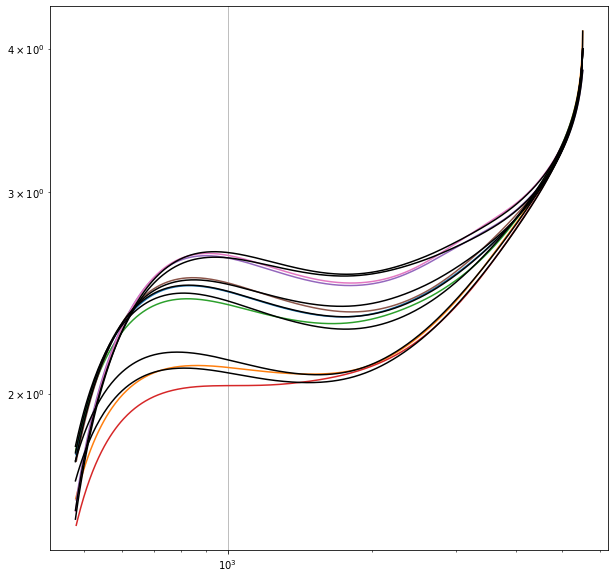

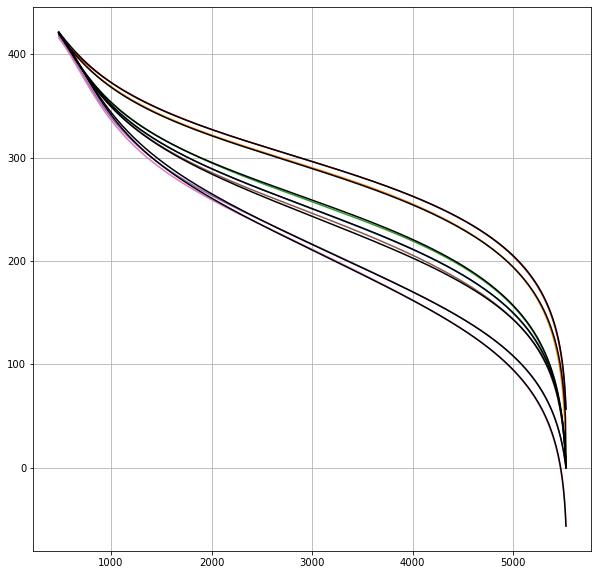

In [160]:
mc = sol['mc']
mc.mc_full['state'][0].shape
X = mc.mc_full['state']

fun = np.log
for x in np.transpose(X, (2,1,0)):
    k = x[2] >= 480
    
    plt.figure(1, figsize=(10,10))
    plt.loglog(x[2,k], fun(x[0,k]/1000-3396.2))
    plt.grid(True)
    
    plt.figure(2, figsize=(10,10))
    plt.plot(x[2,k], x[1,k]/1000)
    

plt.figure(1, figsize=(10,10))
plt.loglog(data['v'], fun(data['h'].T/1000), 'k')    
plt.grid(True)
if 0:
    plt.axis([475, 720, 4.5, 17]) # end
    
plt.figure(2, figsize=(10,10))
plt.plot(data['v'], data['s'].T, 'k')
plt.grid(True)
if 0:
    plt.axis([450, 520, 410, 450]) # end
#     plt.axis([5300, 5550, -100, 100]) # start
    

plt.show()

765 cases (25.5%) are non-behavioral.

Input   KS      P
--------------------
s0     0.39   0.000
fpa0   0.31   0.000
h0     0.10   0.000




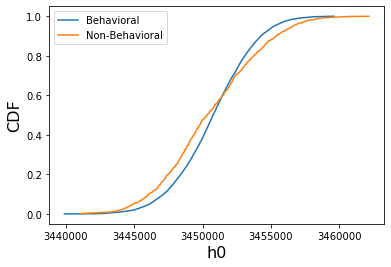

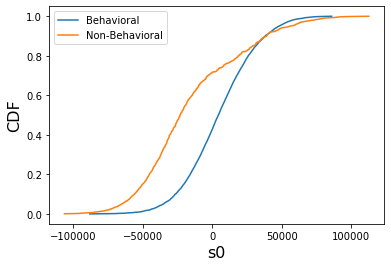

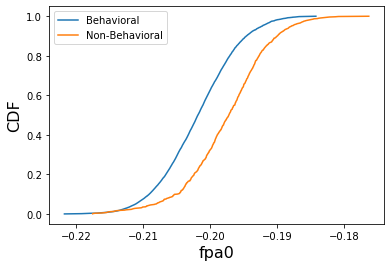

In [143]:
mc = sol['mc']
x0 = mc.mc_full['state'][0][:-1]
MCAnalyze(x0, mc.xf)

 
Generating 2000 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 5.343 km
	UT: 5.174 km
	MC: 4.287 km
3-sigma DR
	DDP: 0.239 km
	UT: 1.457 km
	MC: 8.268 km
 
Generating 2000 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 5.115 km
	UT: 5.029 km
	MC: 4.313 km
3-sigma DR
	DDP: 0.344 km
	UT: 1.785 km
	MC: 6.841 km
 
Generating 2000 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 4.288 km
	UT: 4.204 km
	MC: 4.071 km
3-sigma DR
	DDP: 1.842 km
	UT: 2.217 km
	MC: 8.078 km
 
Generating 2000 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 4.850 km
	UT: 4.795 km
	MC: 4.257 km
3-sigma DR
	DDP: 0.405 km
	UT: 1.290 km
	MC: 6.837 km
 
Generating 2000 samples...
Fixed Gain Controller,  [ 0.072 -0.026 -3.768]
3-sigma Low Altitude
	DDP: 4.706 km
	UT: 4.723 km
	MC: 4.222 km
3-sigma DR
	DDP: 0.521 km
	UT: 1.962 km
	MC: 7.140 km
 
Generating 2000 samples...
F

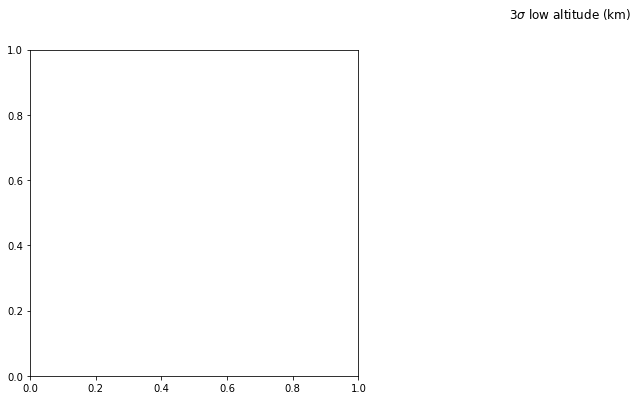

In [152]:
# data = loadmat(os.path.join('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\fixed_gain','Sol11.mat'))
# data
# MonteCarlo()
out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\\iLQR\\solutions\\beta_sweep')
# out = MonteCarloArray('E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\unscented')

ValueError: x and y must have same first dimension, but have shapes (10,) and (25,)

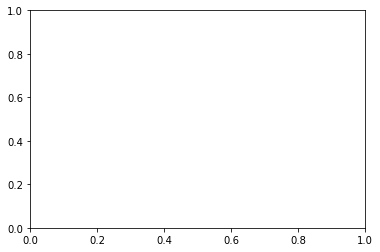

In [139]:
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,1,0]*1000)
plt.plot(np.linspace(0,0.75,10), out[:,1,1:])
plt.figure()
plt.plot(np.linspace(0,0.75,10), out[:,0,:])
plt.show()

In [144]:
mdir = "E:\Documents\GitHub\Research\Matlab"
fname = 'Beta8.mat'
# mdir = 'E:\\Documents\\GitHub\\Research\\Matlab\iLQR\solutions\\' 
# fname = "Robust31.mat"  # numbers indicate weights wh and ws
# fname = "FixedGainTestSolution.mat"

data = loadmat(os.path.join(mdir,fname))

In [145]:
P0 = data['input'][0][0][2]
N = 2000
x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

# X0, mw, cw = Unscented.Transform(x0, P0, k=4)
# X0 = X0.T

mass = 7200.

print(X0.shape)
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 
print(X0.shape)

data.keys()


(3, 2000)
(5, 2000)


dict_keys(['__header__', '__version__', '__globals__', 'u', 'v', 'mean', 'var', 'h', 'fpa', 's', 'weights', 'cost', 'X0', 'P0', 'input', 'sigma_weights', 'L', 'D', 'Dm', 'Dv', 'stats', 'ut'])

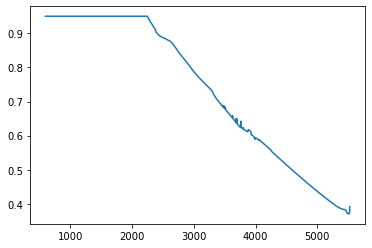

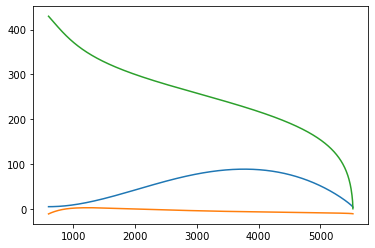

In [146]:
C = ddp_controller(data)
v = data['v'].squeeze()    
xr = C.ref(v)
xr[1] = np.degrees(xr[1])

plt.figure()
plt.plot(v, C.u(v))
# plt.plot(v, C.K(v)[0:2].T)

plt.figure()
plt.plot(v, xr.T)

plt.show()    

In [147]:
mc = VMC()
mc.null_sample(N)
# mc.null_sample(7) # for unscented transform comparison only

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.46, 0.35, CD=CD, CL=CL)

 
Generating 2000 samples...


In [148]:
# mc._run(X0, stepsize=0.25, Ef=150000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})
mc._run(X0, stepsize=[5, 0.1, 1], Ef=100000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})

mean = np.mean(mc.xf, axis=0)
std = np.std(mc.xf, axis=0)
std_ut = data['ut'][0][0][-1][0] # mean alt, low alt, 3*dr

print("3-sigma Low Altitude\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(mean[0]/1000-3396.2-3*std[0]/1000, std_ut[1]))
print("3-sigma DR\n\tMC: {:.3f} km\n\tUT: {:.3f} km".format(3*std[1]/1000, std_ut[2]))

3-sigma Low Altitude
	MC: 5.351 km
	UT: 4.819 km
3-sigma DR
	MC: 4.544 km
	UT: 0.670 km


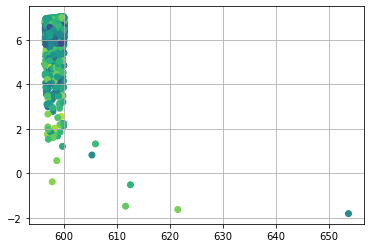

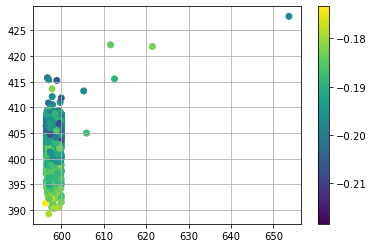

In [32]:
mc.xf.shape  # N x n 

if 0: # Set X0 to unscented above to debug 
    vu = data['ut'][0][0][0]
    xu = data['ut'][0][0][1].T # 
    uu = data['ut'][0][0][2].T

    k = 7

    plt.figure(666, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[0]/1000-3396.2)

    plt.plot(vu, xu[:k].T/1000, 'k--')   

    plt.grid(1)
    plt.figure(669, figsize=(10,10))
    for traj in mc.mc:
        plt.plot(traj.T[2], traj.T[1]/1000)

    plt.plot(vu, xu[2*k:3*k].T, 'k--')   

    plt.grid(1)
    plt.figure(668, figsize=(10,10))
    for traj, control in zip(mc.mc, mc.mcu):
        plt.plot(traj.T[2], control)

    plt.plot(vu, uu, 'k--')   
    plt.grid(1)

#     plt.figure(667, figsize=(10,10))
#     for traj, aero in zip(mc.mc, mc.mca):
#         plt.plot(traj.T[2], aero)

#     # plt.plot(vu, xu[:k].T/1000, 'k--')   
#     plt.plot(v, xr[0].T, 'k')
#     plt.grid(1)

xf = mc.xf.T
plt.figure()
plt.scatter(xf[2], xf[0]/1000-3396.2, c=x0[3])
plt.grid(1)

plt.figure()
plt.scatter(xf[2], xf[1]/1000, c=x0[3])
plt.colorbar()
plt.grid(1)

# Propagate initial covariance to monotonic velocity point

In [ ]:
P0 = np.diag([1, ])  # h s fpa (no velocity term) 

x0 = data['mean'].T[0]
X0 = cp.MvNormal(x0, P0).sample(N, 'L')

mass = 5000.
# reorder and add velocity terms - h s v gamma
X0 =np.array([X0[0]+3396.2e3, X0[2], data['v'][0] + 0*X0[0], X0[1], mass + 0*X0[0]]) 

mc = VMC()
mc.null_sample(N)

mc.control = ddp_controller(data)
mc.set_trigger(velocity_trigger(data['v'][-1]))

vehicle = lambda CD,CL: ConstantAeroEV(1.408, 0.357, CD=CD, CL=CL)

mc._run(X0, stepsize=[5, 0.1, 1], Ef=50000, time_constant=0, debug=0, edl_kwargs={'Longitudinal': True, 'VehicleModel': vehicle})